**LIBRARIES**

In [ ]:
!pip install --upgrade pip
!pip install matplotlib
!pip install tensorflow
!pip install keras
!pip install visualkeras
!pip install tf-keras-vis

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import shutil
import random
import itertools
import pprint
import json
from enum import Enum

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
import visualkeras
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from tf_keras_vis.utils.scores import CategoricalScore
print(tf.__version__)

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
current_directory = os.getcwd()
base_dir = os.path.dirname(os.path.abspath('__file__'))
os.chdir(base_dir)

# **DATA SOURCES**

In [8]:
base_folder = '.'
# adjust the variable base_folder to whatever directory will contain esca_dataset and esca_dataset_swapped_bg

data_folders = {
    '.': base_folder,
    'esca_dataset': {
        '.': os.path.join(base_folder, 'esca_dataset'),
        'train': {
            '.': os.path.join(base_folder, 'esca_dataset', 'train'),
            'esca': os.path.join(base_folder, 'esca_dataset', 'train', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset', 'train', 'healthy')
        },
        'test': {
            '.': os.path.join(base_folder, 'esca_dataset', 'test'),
            'esca':    os.path.join(base_folder, 'esca_dataset', 'test', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset', 'test', 'healthy')
        },
        'validation': {
            '.': os.path.join(base_folder, 'esca_dataset', 'validation'),
            'esca':    os.path.join(base_folder, 'esca_dataset', 'validation', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset', 'validation', 'healthy')
        }
    },
    'esca_dataset_swapped_bg': {
        '.': os.path.join(base_folder, 'esca_dataset_swapped_bg'),
        'train': {
            '.': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'train'),
            'esca':    os.path.join(base_folder, 'esca_dataset_swapped_bg', 'train', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'train', 'healthy')
        },
        'test': {
            '.': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'test'),
            'esca':    os.path.join(base_folder, 'esca_dataset_swapped_bg', 'test', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'test', 'healthy')
        },
        'validation': {
            '.': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'validation'),
            'esca': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'validation', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_swapped_bg', 'validation', 'healthy')
        }
    },
    'esca_dataset_mixed': {
        '.': os.path.join(base_folder, 'esca_dataset_mixed'),
        'train': {
            '.': os.path.join(base_folder, 'esca_dataset_mixed', 'train'),
            'esca':    os.path.join(base_folder, 'esca_dataset_mixed', 'train', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_mixed', 'train', 'healthy')
        },
        'test': {
            '.': os.path.join(base_folder, 'esca_dataset_mixed', 'test'),
            'esca':    os.path.join(base_folder, 'esca_dataset_mixed', 'test', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_mixed', 'test', 'healthy')
        },
        'validation': {
            '.': os.path.join(base_folder, 'esca_dataset_mixed', 'validation'),
            'esca': os.path.join(base_folder, 'esca_dataset_mixed', 'validation', 'esca'),
            'healthy': os.path.join(base_folder, 'esca_dataset_mixed', 'validation', 'healthy')
        }
    }
}

# Serializing json
json_object = json.dumps(data_folders, indent = 4)
print(json_object)

{
    ".": ".",
    "esca_dataset": {
        ".": "./esca_dataset",
        "train": {
            ".": "./esca_dataset/train",
            "esca": "./esca_dataset/train/esca",
            "healthy": "./esca_dataset/train/healthy"
        },
        "test": {
            ".": "./esca_dataset/test",
            "esca": "./esca_dataset/test/esca",
            "healthy": "./esca_dataset/test/healthy"
        },
        "validation": {
            ".": "./esca_dataset/validation",
            "esca": "./esca_dataset/validation/esca",
            "healthy": "./esca_dataset/validation/healthy"
        }
    },
    "esca_dataset_swapped_bg": {
        ".": "./esca_dataset_swapped_bg",
        "train": {
            ".": "./esca_dataset_swapped_bg/train",
            "esca": "./esca_dataset_swapped_bg/train/esca",
            "healthy": "./esca_dataset_swapped_bg/train/healthy"
        },
        "test": {
            ".": "./esca_dataset_swapped_bg/test",
            "esca": "./esca_dataset_

In [5]:
!python --version

Python 3.10.8


**FUNCTIONS**

In [9]:
def count_images(folder_path):
    total_files = 0
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        for foldername, subfolders, filenames in os.walk(folder_path):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                if os.path.isfile(file_path) and (file_path.endswith('.jpg') or file_path.endswith('.jpeg') or file_path.endswith('.JPG') or file_path.endswith('.JPEG')):
                    total_files += 1
    return total_files

In [11]:
data_folders_info = {
    'esca_dataset': {
        'train': {
            'esca':    count_images(data_folders['esca_dataset']['train']['esca']),
            'healthy': count_images(data_folders['esca_dataset']['train']['healthy'])
        },
        'test': {
            'esca':    count_images(data_folders['esca_dataset']['test']['esca']),
            'healthy': count_images(data_folders['esca_dataset']['test']['healthy'])
        },
        'validation': {
            'esca':    count_images(data_folders['esca_dataset']['validation']['esca']),
            'healthy': count_images(data_folders['esca_dataset']['validation']['healthy'])
        }
    },
    'esca_dataset_swapped_bg': {
        'train': {
            'esca':    count_images(data_folders['esca_dataset_swapped_bg']['train']['esca']),
            'healthy': count_images(data_folders['esca_dataset_swapped_bg']['train']['healthy'])
        },
        'test': {
            'esca':    count_images(data_folders['esca_dataset_swapped_bg']['test']['esca']),
            'healthy': count_images(data_folders['esca_dataset_swapped_bg']['test']['healthy'])
        },
        'validation': {
            'esca':    count_images(data_folders['esca_dataset_swapped_bg']['validation']['esca']),
            'healthy': count_images(data_folders['esca_dataset_swapped_bg']['validation']['healthy'])
        }
    },
    'esca_dataset_mixed': {
        'train': {
            'esca':    count_images(data_folders['esca_dataset_mixed']['train']['esca']),
            'healthy': count_images(data_folders['esca_dataset_mixed']['train']['healthy'])
        },
        'test': {
            'esca':    count_images(data_folders['esca_dataset_mixed']['test']['esca']),
            'healthy': count_images(data_folders['esca_dataset_mixed']['test']['healthy'])
        },
        'validation': {
            'esca':    count_images(data_folders['esca_dataset_mixed']['validation']['esca']),
            'healthy': count_images(data_folders['esca_dataset_mixed']['validation']['healthy'])
        }
    }
}

# Serializing json
json_object = json.dumps(data_folders_info, indent = 4)
print(json_object)

{
    "esca_dataset": {
        "train": {
            "esca": 8680,
            "healthy": 8638
        },
        "test": {
            "esca": 134,
            "healthy": 133
        },
        "validation": {
            "esca": 134,
            "healthy": 132
        }
    },
    "esca_dataset_swapped_bg": {
        "train": {
            "esca": 8638,
            "healthy": 8694
        },
        "test": {
            "esca": 133,
            "healthy": 134
        },
        "validation": {
            "esca": 132,
            "healthy": 133
        }
    },
    "esca_dataset_mixed": {
        "train": {
            "esca": 17318,
            "healthy": 17332
        },
        "test": {
            "esca": 267,
            "healthy": 267
        },
        "validation": {
            "esca": 266,
            "healthy": 265
        }
    }
}


# **Training MyModel**

In [12]:
class Labels(Enum):
    ESCA = 0
    HEALTHY = 1

# dimensione delle immagini
img_width, img_height = 128, 128

# input shape
if keras.backend.image_data_format() == 'channels_first':
    ARCHIVE_DATASET = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    print(f"input_shape: {input_shape}")

# Fix seed for results reproducibility
seed_value = 1
#tf.random.set_seed(1)

# number of test images
n_class = 2
epochs = 30
batch_size = 64

input_shape: (128, 128, 3)


# **PREPARE DATSETS FOR MODEL TRAINING**

**EXECUTE THE FOLLOWING CELL WHEN YOU WANT TO TRAIN THE MODEL USING ONLY ORIGINAL IMAGES**

In [19]:
train_dataset = image_dataset_from_directory(data_folders['esca_dataset']['train']['.'],
                                             labels='inferred',
                                             shuffle=True,
                                             seed=seed_value,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             image_size=(img_width, img_height),
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(data_folders['esca_dataset']['validation']['.'],
                                                  labels='inferred',
                                                  shuffle=True,
                                                  seed=seed_value,
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  image_size=(img_width, img_height),
                                                  label_mode='categorical')

Found 17318 files belonging to 2 classes.
Found 266 files belonging to 2 classes.


**EXECUTE THE FOLLOWING CELL ONLY WHEN YOU WANT TO TRAIN A MODEL USING ALSO IMAGES WITH SWAPPED BACKGROUNDS**

In [13]:
train_dataset = image_dataset_from_directory(data_folders['esca_dataset_mixed']['train']['.'],
                                             labels='inferred',
                                             shuffle=True,
                                             seed=seed_value,
                                             color_mode='rgb',
                                             batch_size=batch_size,
                                             image_size=(img_width, img_height),
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(data_folders['esca_dataset_mixed']['validation']['.'],
                                                  labels='inferred',
                                                  shuffle=True,
                                                  seed=seed_value,
                                                  color_mode='rgb',
                                                  batch_size=batch_size,
                                                  image_size=(img_width, img_height),
                                                  label_mode='categorical')

Found 34650 files belonging to 2 classes.
Found 531 files belonging to 2 classes.


**EXECUTE THE FOLLOWING CELL IN ALL CASES TO COMPLETE DATASET PREPARATION FOR TRAINING**

In [14]:
train_dataset = train_dataset.map(lambda images, labels: ((images/255.0), labels))
validation_dataset = validation_dataset.map(lambda images, labels: ((images/255.0), labels))

# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

**MODEL STRUCT**

In [15]:
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

model = Sequential()

# Feature Learning block:
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu',input_shape=input_shape, name='conv1')),
model.add(MaxPooling2D(pool_size=(3,3))),
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', name='conv2')),
model.add(MaxPooling2D(pool_size=(3,3))),
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', name='conv3')),
model.add(MaxPooling2D(pool_size=(2,2))),

# Classification block:
model.add(Flatten()),
model.add(Dense(units = 512, activation='relu', name='dense1')),
model.add(Dropout(0.5))
model.add(Dense(units = 2, activation = 'softmax', name='output_layer'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 16)        0         
 D)                                                              
                                                                 
 conv2 (Conv2D)              (None, 42, 42, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv3 (Conv2D)              (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 64)          0

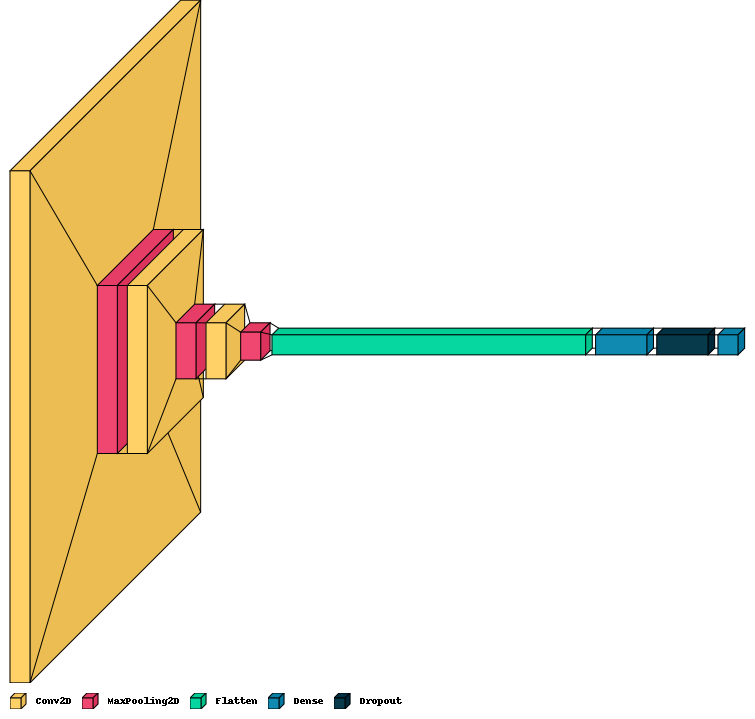

In [ ]:
visualkeras.layered_view(model, legend=True)

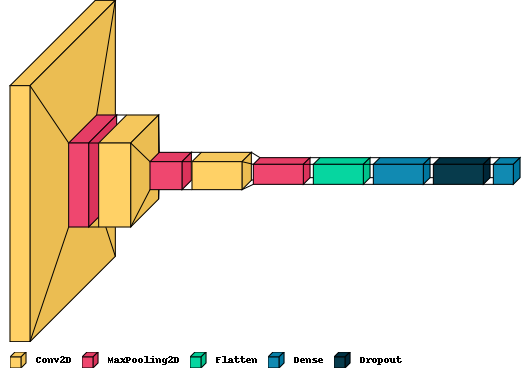

In [ ]:
visualkeras.layered_view(model, scale_xy=2, scale_z=1, max_z=50, legend=True)

**COMPILE THE MODEL**

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(learning_rate=1, name='Adadelta'),
              metrics=['accuracy'])

**TRAINING AND SAVING THE MODEL**

In [17]:
# training
start = time.time()

with tf.device('/device:GPU:0'):

  history = model.fit(
      train_dataset,
      #steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      batch_size = batch_size,
      validation_data=validation_dataset,
      verbose=True)
      #validation_steps=nb_validation_samples // batch_size)

print ('Time taken for training: {} sec\n'.format(time.time() - start))

Epoch 1/30
542/542 [==============================] - 523s 948ms/step - loss: 0.4275 - accuracy: 0.7935 - val_loss: 0.1899 - val_accuracy: 0.9303
Epoch 2/30
542/542 [==============================] - 524s 952ms/step - loss: 0.1442 - accuracy: 0.9457 - val_loss: 0.1406 - val_accuracy: 0.9435
Epoch 3/30
542/542 [==============================] - 817s 1s/step - loss: 0.0814 - accuracy: 0.9708 - val_loss: 0.0506 - val_accuracy: 0.9774
Epoch 4/30


2024-02-19 18:30:45.305143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 445 of 512
2024-02-19 18:30:47.014862: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


542/542 [==============================] - 577s 1s/step - loss: 0.0525 - accuracy: 0.9816 - val_loss: 0.0645 - val_accuracy: 0.9812
Epoch 5/30
542/542 [==============================] - 536s 974ms/step - loss: 0.0383 - accuracy: 0.9869 - val_loss: 0.0618 - val_accuracy: 0.9793
Epoch 6/30
542/542 [==============================] - 528s 959ms/step - loss: 0.0264 - accuracy: 0.9911 - val_loss: 0.0354 - val_accuracy: 0.9849
Epoch 7/30
542/542 [==============================] - 526s 954ms/step - loss: 0.0195 - accuracy: 0.9932 - val_loss: 0.0278 - val_accuracy: 0.9868
Epoch 8/30
542/542 [==============================] - 529s 960ms/step - loss: 0.0155 - accuracy: 0.9952 - val_loss: 0.0248 - val_accuracy: 0.9906
Epoch 9/30
542/542 [==============================] - 541s 983ms/step - loss: 0.0098 - accuracy: 0.9965 - val_loss: 0.0316 - val_accuracy: 0.9887
Epoch 10/30
542/542 [==============================] - 495s 899ms/step - loss: 0.0100 - accuracy: 0.9966 - val_loss: 0.0231 - val_accuracy

In [18]:
# Define function to estimate model size

def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' KB')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' MB')
    else:
        return print('File size: ' + str(size) + ' bytes')

**EXECUTE THE FOLLOWING CELL WHEN YOU TRAINED THE MODEL ON JUST THE STANDARD DATASET**

In [17]:
MODELS_PATH = '.'
model.save(os.path.join(MODELS_PATH, 'CNN_Esca_model.keras'))
# Compute model size
convert_bytes(get_file_size(os.path.join(MODELS_PATH, 'CNN_Esca_model.keras')), "MB")
convert_bytes(get_file_size(os.path.join(MODELS_PATH, 'CNN_Esca_model.keras')), "KB")
get_file_size(os.path.join(MODELS_PATH, 'CNN_Esca_model.keras'))

File size: 18.707 MB
File size: 19156.046 KB


19615791

**EXECUTE THE FOLLOWING CELL WHEN YOU TRAINED THE MODEL ON THE DATASET ENRICHED WITH SWAPPED BACKGROUND IMAGES**

In [19]:
MODELS_PATH = '.'
model.save(os.path.join(MODELS_PATH, 'CNN_Esca_model_retrained.keras'))
# Compute model size
convert_bytes(get_file_size(os.path.join(MODELS_PATH, 'CNN_Esca_model_retrained.keras')), "MB")
convert_bytes(get_file_size(os.path.join(MODELS_PATH, 'CNN_Esca_model_retrained.keras')), "KB")
get_file_size(os.path.join(MODELS_PATH, 'CNN_Esca_model_retrained.keras'))

File size: 18.707 MB
File size: 19156.046 KB


19615791

**GRAPH OF THE TRAINING AND VALIDATION PROGRESS**

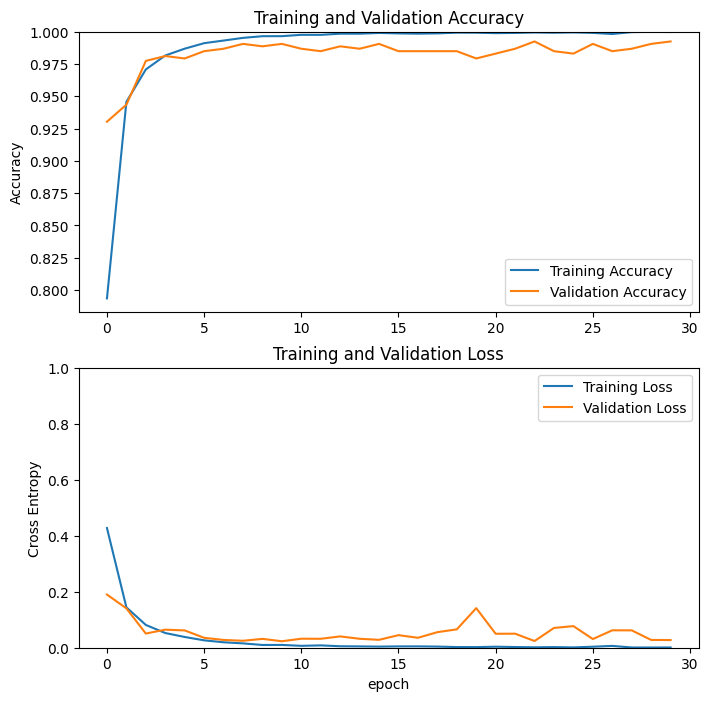

In [20]:
# plot the graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()